### functionality

### required directory structure

### imports and inputs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import math
import statistics as stat
from scipy.stats import pearsonr
import os

from packages import miscellaneous as mc
from packages import timeconvert as tc
from packages import plotstyle as ps

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
sb.set_theme(style="white",font="serif")

graph = 'z'

date = '8_9_2021 (daytime)'

timeRange = ["12","18"] # Start and end hour in 24-hour time: ["HH","HH"]. For title only.

timeToScale = False # If true, tick labels are daily. Else, tick labels occur only on observation days.

Save = False # False to display, True to save to /offsetplots/ subdirectory.

numOutliers = 0 # Number of outliers you'd like to exclude. If not needed, set to 0.

# Code is general to antennas, but plot arrangements are specific, so structure of lists below is fixed.
refants = ['DA59','DV11','DA49','DV12','PM01','DV07'] # Must be three pairs [A,A,B,B,C,C], where A,A are central.
pairLoc = ['Center','Southwest','East'] # Must be three corresponding locations [A,B,C].

directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/' # Directory of "Observational Data", assuming specified structure

### general initializations

In [2]:
weaants = ['Meteo129','Meteo130','Meteo131','Meteo201','Meteo309','Meteo410','MeteoCentral']

directory = directory+'/'+date
genDir = directory+'/asdm/'

numObs = mc.numObs(genDir)

if graph == 'x':
    index = 0
elif graph == 'y':
    index = 1
else:
    index = 2
    
# Create new "offsetplots" directory within "Observational Data" subdirectory
if timeToScale: subdirName = '/offsetplotsConst/'
else: subdirName = '/offsetplots/'
if not os.path.isdir(directory+subdirName):
    os.mkdir(directory+subdirName)
    
# Prepare x-values           NOTE: WILL NEED TO BE MODIFIED BASED ON MONTH
tempArr = pd.read_csv(directory+'/offsetdata/'+refants[0]+'.csv')
timeList = [tc.UnixtoFormattedTime(int(ele)) for ele in tempArr.loc[:,'time']]
x = []
for time in timeList:
    if time[1] == "7":
        x.append(int(time[3:5]))
    else: x.append(int(time[3:5])+31)
offset = x[0]-1
for i in range(len(x)): x[i] = x[i] - offset
#x = np.array(x)
minTimeLabel = str(int(timeList[0][:2]))+'-'+str(int(timeList[0][3:5]))
maxTimeLabel = str(int(timeList[-1][:2]))+'-'+str(int(timeList[-1][3:5]))
maxTimeIndex = x[-1]

# Prepare time labels
timeSeries = ['',minTimeLabel]
while timeSeries[-1] != maxTimeLabel:
    if timeSeries[-1] != "7-31":
        temp = timeSeries[-1].split('-')
        timeSeries.append(temp[0]+'-'+str(int(temp[1])+1))
    else: timeSeries.append('8-1')

# magnitude w/ mean-based normalization

### specific initializations

In [3]:
magProbs = np.empty((np.shape(refants)[0],numObs,2),dtype='U25')
mag = np.empty((np.shape(refants)[0],numObs,6),dtype='float')
if timeToScale: 
    xMag = x
    xticks = range(maxTimeIndex+1)
else:
    xMag = range(1,numObs+1)
    xticks = range(numObs+1)
    
    # Prepare time labels
    timeSeries = []
    temp = pd.read_csv(directory+'/offsetdata/'+refants[0]+'.csv')[['time']]
    for time in range(temp.shape[0]):
        timeSeries.append(tc.UnixtoFormattedTime(temp.loc[time]))
    
    timeSeries.append("")

########## magnitude-specific pos data

# Data extraction from offsetdata directory
for ant in range(np.shape(refants)[0]):
    arr = pd.read_csv(directory+'/offsetdata/'+refants[ant]+'.csv')
    arr = arr.loc[:,'poserrX':'poserr()Z']
    
    # Mean-based normalization
    for coord in range(3):
        offset = np.average(arr.iloc[:,coord].fillna(0))
        arr.iloc[:,coord] = arr.iloc[:,coord]-offset
    
    # Eliminating outliers
    tempList = arr.iloc[:,index]
    tempList = tempList.fillna(0).abs().sort_values(ascending=False)
    if numOutliers != 0:
        for row in range(numOutliers):
            arr.loc[tempList.index[row],:] = 0
            
    for obs in range(numObs):
        # If there's a problem in the data, prep it for the next loop
        if arr.iloc[obs].isnull().values.any():
            L = np.where(magProbs[ant,:,0] == "")[0][0]
            magProbs[ant,L,0] = obs
            magProbs[ant,L,1] = xMag[obs]
            mag[ant,obs,:] = 0
        # Else, transfer the data
        else: mag[ant,obs,:] = arr.iloc[obs]

# If there's a problem in the data, take the data from the previous observation (or the next, if the previous is
# not available) and update magProbs, which will allow us to circle the problem areas in our plot.
#for ant in range(np.shape(refants)[0]):
    #if magProbs[ant,0,0] != "":
        #for prob in range(np.where(magProbs[ant,:,0] == "")[0][0]):
            #k = 1
            #if int(magProbs[ant,prob,0]) == 0:
                #while np.isnan(np.sum(mag[ant,int(magProbs[ant,prob,0])+k,:])):
                    #k += 1
                    
                #mag[ant,int(magProbs[ant,prob,0]),:] = mag[ant,int(magProbs[ant,prob,0])+k,:]
            #else:
                #while np.isnan(np.sum(mag[ant,int(magProbs[ant,prob,0])-k,:])):
                    #k += 1
                    
                #mag[ant,int(magProbs[ant,prob,0]),:] = mag[ant,int(magProbs[ant,prob,0])-k,:]

### combined plot initializations

In [4]:
magProbsAvg = np.empty((int(np.shape(refants)[0]/2),numObs,2),dtype='U25')
magAvg = np.zeros((int(np.shape(refants)[0]/2),numObs,6),dtype='float')

for ant in range(int(np.shape(refants)[0]/2)):
    magAvg[ant,:] = (mag[ant*2,:] + mag[ant*2+1,:]) / 2
        
for ant in range(np.shape(refants)[0]):
    pair = ant // 2
    if magProbs[ant,0,0] != "":
        for prob in range(np.where(magProbs[ant,:,0] == "")[0][0]):
            L = np.where(magProbsAvg[pair,:,0] == "")[0][0]
            magProbsAvg[pair,L,:] = magProbs[ant,prob,:]
for pair in range(int(np.shape(refants)[0]/2)):
    if magProbsAvg[pair,0,0] != "":
        for prob in range(int(np.where(magProbsAvg[pair,:,0] == "")[0][0])):
            magAvg[pair,int(magProbsAvg[pair,prob,0]),:] = 0 # this should go after offsetting
            if int(magProbsAvg[pair,prob,0]) == 0: magAvg[pair,int(magProbsAvg[pair,prob,0]),:] = magAvg[pair,int(magProbsAvg[pair,prob,0])+1,:]
            else: magAvg[pair,int(magProbsAvg[pair,prob,0]),:] = magAvg[pair,int(magProbsAvg[pair,prob,0])-1,:]

                
for pair in range(int(np.shape(refants)[0]/2)):
    for coord in range(3):
        offset = np.average(magAvg[pair,:,coord])
        magAvg[pair,:,coord] = magAvg[pair,:,coord] - offset

### extrema

In [5]:
extrema = np.zeros((np.shape(refants)[0],2),dtype='float')
for ant in range(np.shape(refants)[0]):
    extrema[ant,0], extrema[ant,1] = np.max(mag[ant,:,index]+mag[ant,:,index+3]), np.min(mag[ant,:,index]-mag[ant,:,index+3])
    
temp = np.max([abs(np.max(extrema[:,0])), abs(np.min(extrema[:,1]))])
ymaxMag, yminMag = temp * 1.25, -(temp * 1.25)

## plot 

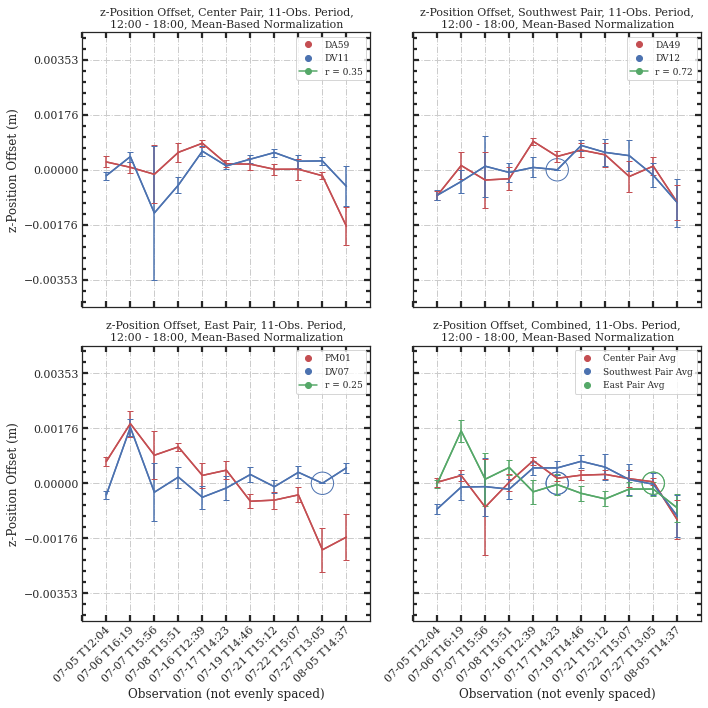

In [6]:
fig, axes = plt.subplots(2,2,figsize=(10,10),sharey=True,sharex=True)

ax = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

for i in range(3):
    temp = pd.DataFrame(np.column_stack((xMag,mag[i*2,:,index],mag[i*2,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='r')
    ax[i].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color='r',capsize=3)
    temp = pd.DataFrame(np.column_stack((xMag,mag[i*2+1,:,index],mag[i*2+1,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='b')
    ax[i].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color='b',capsize=3)
    
colors = ['r','b','g']
for i in range(3):
    temp = pd.DataFrame(np.column_stack((xMag,magAvg[i,:,index],magAvg[i,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[3], x='x', y='y', data=temp, color=colors[i])
    ax[3].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color=colors[i],capsize=3)
    
for ant in range(len(refants)):
    if magProbs[ant,0,0] != "":
        for row in range(np.where(magProbs[ant,:,0] == "")[0][0]):
            ec = colors[ant % 2]
            ax[ant//2].scatter(float(magProbs[ant,row,1]),0,s=500,c='none',edgecolor=ec,linewidth=1)
            
    if magProbsAvg[ant//2,0,0] != "":
        for row in range(np.where(magProbsAvg[ant//2,:,0] == "")[0][0]):
            ec = colors[ant // 2]
            ax[3].scatter(float(magProbsAvg[ant//2,row,1]),0,s=500,c='none',edgecolor=ec,linewidth=1)
            
handles = []
for i in range(3):
    handles.append([Line2D([0],[0],marker='o',color='r',label=refants[i*2],linewidth=0),
          Line2D([0],[0],marker='o',color='b',label=refants[i*2+1],linewidth=0),
            Line2D([0],[0],marker='o',color='g',label="r = %0.2f"%pearsonr(mag[i*2,:,index],mag[i*2+1,:,index])[0])])
handles.append([Line2D([0],[0],marker='o',color='r',label=pairLoc[0]+' Pair Avg',linewidth=0),
          Line2D([0],[0],marker='o',color='b',label=pairLoc[1]+' Pair Avg',linewidth=0),
          Line2D([0],[0],marker='o',color='g',label=pairLoc[2]+' Pair Avg',linewidth=0)])
            
names = [pairLoc[0]+' Pair, ',pairLoc[1]+' Pair, ',pairLoc[2]+' Pair, ','Combined, ']
for i in range(4):
    ps.plotNonDescript(ax[i],title=graph+'-Position Offset, '+names[i]+str(numObs)+'-Obs. Period,\n'+
                   timeRange[0]+':00 - '+timeRange[1]+':00, Mean-Based Normalization',ymax=ymaxMag,
                   ymin=yminMag,titlesize=11,xlabel='Observation (not evenly spaced)',ylabel=graph+'-Position '
                   +'Offset (m)',xticks=xticks,xticklabels=timeSeries,yticks=True,handles=handles[i])

plt.tight_layout()

if Save:
    plt.savefig(directory+subdirName+'mag'+graph.capitalize()+'.png', bbox_inches='tight')
    plt.close()
else: plt.show()

# delta w/ mean-based normalization

### specific initializations

In [7]:
deltaProbs = np.empty((np.shape(refants)[0],numObs-1,2),dtype='U25')
delta = np.empty((np.shape(refants)[0],numObs-1,6),dtype='float')
if timeToScale: 
    xDelta = x[1:]
    xticks = np.arange(maxTimeIndex+1)+0.5
else:
    xDelta = range(1,numObs)
    xticks = np.array(range(numObs+1),dtype='float')+0.5
    
    # Prepare time labels
    timeSeries = []
    temp = pd.read_csv(directory+'/offsetdata/'+refants[0]+'.csv')[['time']]
    for time in range(temp.shape[0]):
        timeSeries.append(tc.UnixtoFormattedTime(temp.loc[time]))
    
    timeSeries.append("")
    
########## delta-specific pos data

# Data extraction from offsetdata directory
for ant in range(np.shape(refants)[0]):
    arr = pd.read_csv(directory+'/offsetdata/'+refants[ant]+'.csv')
    arr = arr.loc[:,'poserrX':'poserr()Z']
    
    # Mean-based normalization
    for coord in range(3):
        offset = np.average(arr.iloc[:,coord].fillna(0))
        arr.iloc[:,coord] = arr.iloc[:,coord]-offset
    
    # Eliminating outliers
    tempList = arr.iloc[:,index]
    tempList = tempList.fillna(0).abs().sort_values(ascending=False)
    if numOutliers != 0:
        for row in range(numOutliers):
            arr.loc[tempList.index[row],:] = 0

    for obs in range(numObs-1):
        # If there's a problem in the data, prep it for the next loop
        if arr.iloc[obs+1].isnull().values.any() or arr.iloc[obs].isnull().values.any():
            L = np.where(deltaProbs[ant,:,0] == "")[0][0]
            deltaProbs[ant,L,0] = obs
            deltaProbs[ant,L,1] = xDelta[obs]
            delta[ant,obs,:] = 0
        # Else, transfer the data
        else: 
            delta[ant,obs,:3] = arr.iloc[obs+1,:3]-arr.iloc[obs,:3]
            if arr.iat[obs+1,index+3] > arr.iat[obs,index+3]:
                delta[ant,obs,3:] = arr.iloc[obs+1,3:]
            else: delta[ant,obs,3:] = arr.iloc[obs,3:]
            

# If there's a problem in the data, take the data from the previous observation (or the next, if the previous is
# not available) and update deltaProbs, which will allow us to circle the problem areas in our plot.
#for ant in range(np.shape(refants)[0]):
    #if deltaProbs[ant,0,0] != "":
        #for prob in range(np.where(deltaProbs[ant,:,0] == "")[0][0]):
            #k = 1
            #if int(deltaProbs[ant,prob,0]) == 0:
                #while np.isnan(np.sum(delta[ant,int(deltaProbs[ant,prob,0])+k,:])):
                    #k += 1
                    
                #delta[ant,int(deltaProbs[ant,prob,0]),:] = delta[ant,int(deltaProbs[ant,prob,0])+k,:]
            #else:
                #while np.isnan(np.sum(delta[ant,int(deltaProbs[ant,prob,0])-k,:])):
                    #k += 1
                    
                #delta[ant,int(deltaProbs[ant,prob,0]),:] = delta[ant,int(deltaProbs[ant,prob,0])-k,:]


### combined plot initializations

In [8]:
deltaProbsAvg = np.empty((int(np.shape(refants)[0]/2),numObs-1,2),dtype='U25')
deltaAvg = np.zeros((int(np.shape(refants)[0]/2),numObs-1,6),dtype='float')

for ant in range(int(np.shape(refants)[0]/2)):
    deltaAvg[ant,:] = (delta[ant*2,:] + delta[ant*2+1,:]) / 2
        
for ant in range(np.shape(refants)[0]):
    pair = ant // 2
    if deltaProbs[ant,0,0] != "":
        for prob in range(np.where(deltaProbs[ant,:,0] == "")[0][0]):
            L = np.where(deltaProbsAvg[pair,:,0] == "")[0][0]
            deltaProbsAvg[pair,L,:] = deltaProbs[ant,prob,:]
for pair in range(int(np.shape(refants)[0]/2)):
    if deltaProbsAvg[pair,0,0] != "":
        for prob in range(int(np.where(deltaProbsAvg[pair,:,0] == "")[0][0])):
            deltaAvg[pair,int(deltaProbsAvg[pair,prob,0]),:] = 0
            #if int(deltaProbsAvg[pair,prob,0]) == 0: deltaAvg[pair,int(deltaProbsAvg[pair,prob,0]),:] = deltaAvg[pair,int(deltaProbsAvg[pair,prob,0])+1,:]
            #else: deltaAvg[pair,int(deltaProbsAvg[pair,prob,0]),:] = deltaAvg[pair,int(deltaProbsAvg[pair,prob,0])-1,:]

                
for pair in range(int(np.shape(refants)[0]/2)):
    for coord in range(3):
        offset = np.average(deltaAvg[pair,:,coord])
        deltaAvg[pair,:,coord] = deltaAvg[pair,:,coord] - offset

### extrema

In [9]:
extrema = np.zeros((np.shape(refants)[0],2),dtype='float')
for ant in range(np.shape(refants)[0]):
    extrema[ant,0], extrema[ant,1] = np.max(delta[ant,:,index]+delta[ant,:,index+3]), np.min(delta[ant,:,index]-delta[ant,:,index+3])
    
temp = np.max([abs(np.max(extrema[:,0])), abs(np.min(extrema[:,1]))])
ymaxDelta, yminDelta = temp * 1.25, -(temp * 1.25)

## plot

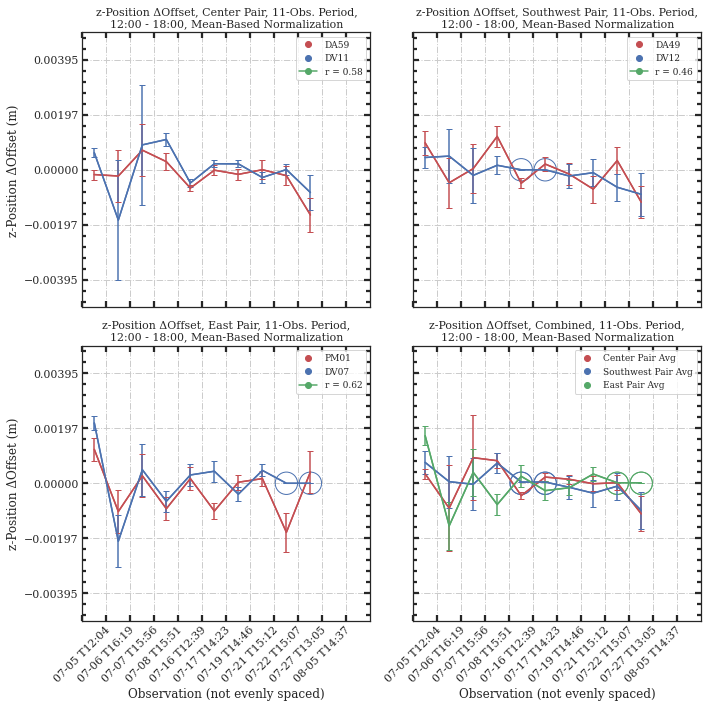

In [10]:
fig, axes = plt.subplots(2,2,figsize=(10,10),sharey=True,sharex=True)

ax = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

for i in range(3):
    temp = pd.DataFrame(np.column_stack((xDelta,delta[i*2,:,index],delta[i*2,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='r')
    ax[i].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color='r',capsize=3)
    temp = pd.DataFrame(np.column_stack((xDelta,delta[i*2+1,:,index],delta[i*2+1,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='b')
    ax[i].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color='b',capsize=3)
    
colors = ['r','b','g']
for i in range(3):
    temp = pd.DataFrame(np.column_stack((xDelta,deltaAvg[i,:,index],deltaAvg[i,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[3], x='x', y='y', data=temp, color=colors[i])
    ax[3].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color=colors[i],capsize=3)
    
for ant in range(len(refants)):
    if deltaProbs[ant,0,0] != "":
        for row in range(np.where(deltaProbs[ant,:,0] == "")[0][0]):
            ec = colors[ant % 2]
            ax[ant//2].scatter(float(deltaProbs[ant,row,1]),0,s=500,c='none',edgecolor=ec,linewidth=1)
            
    if deltaProbsAvg[ant//2,0,0] != "":
        for row in range(np.where(deltaProbsAvg[ant//2,:,0] == "")[0][0]):
            ec = colors[ant // 2]
            ax[3].scatter(float(deltaProbsAvg[ant//2,row,1]),0,s=500,c='none',edgecolor=ec,linewidth=1)

handles = []
for i in range(3):
    handles.append([Line2D([0],[0],marker='o',color='r',label=refants[i*2],linewidth=0),
          Line2D([0],[0],marker='o',color='b',label=refants[i*2+1],linewidth=0),
            Line2D([0],[0],marker='o',color='g',label="r = %0.2f"%pearsonr(delta[i*2,:,index],delta[i*2+1,:,index])[0])])
handles.append([Line2D([0],[0],marker='o',color='r',label=pairLoc[0]+' Pair Avg',linewidth=0),
          Line2D([0],[0],marker='o',color='b',label=pairLoc[1]+' Pair Avg',linewidth=0),
          Line2D([0],[0],marker='o',color='g',label=pairLoc[2]+' Pair Avg',linewidth=0)])
            
names = [pairLoc[0]+' Pair, ',pairLoc[1]+' Pair, ',pairLoc[2]+' Pair, ','Combined, ']
for i in range(4):
    ps.plotNonDescript(ax[i],title=graph+'-Position ΔOffset, '+names[i]+str(numObs)+'-Obs. Period,\n'+
                   timeRange[0]+':00 - '+timeRange[1]+':00, Mean-Based Normalization',ymax=ymaxDelta,
                   ymin=yminDelta,titlesize=11,xlabel='Observation (not evenly spaced)',ylabel=graph+'-Position '
                   +'ΔOffset (m)',xticks=xticks,xticklabels=timeSeries,yticks=True,handles=handles[i])

plt.tight_layout()

if Save:
    plt.savefig(directory+subdirName+'delta'+graph.capitalize()+'.png', bbox_inches='tight')
    plt.close()
else: plt.show()

# mag (offset & weather) w/ mean-based normalization

### specific initializations

In [11]:
magWeaProbs = np.empty((np.shape(weaants)[0],numObs,2),dtype='U25')
magWea = np.empty((np.shape(weaants)[0],numObs,6),dtype='float')
if timeToScale: xticks = range(maxTimeIndex+1)
else:
    xticks = range(numObs+1)
    
    # Prepare time labels
    timeSeries = []
    temp = pd.read_csv(directory+'/offsetdata/'+refants[0]+'.csv')[['time']]
    for time in range(temp.shape[0]):
        timeSeries.append(tc.UnixtoFormattedTime(temp.loc[time]))
    
    timeSeries.append("")

########## magnitude-specific wea data

# Data extraction from weatherdata directory
for ant in range(np.shape(weaants)[0]):
    arr = pd.read_csv(directory+'/weatherdata/'+weaants[ant]+'.csv')
    arr = arr.loc[:,'pressure':'windMax']
    
    for obs in range(numObs):
        # If there's a problem in the data, prep it for the next loop
        if arr.iloc[obs].isnull().values.any():
            L = np.where(magWeaProbs[ant,:,0] == "")[0][0]
            magWeaProbs[ant,L,0] = obs
            magWeaProbs[ant,L,1] = xMag[obs]
            magWea[ant,obs,:] = 0
        # Else, transfer the data
        else: magWea[ant,obs,:] = arr.iloc[obs]
            
# If there's a problem in the data, take the data from the previous observation (or the next, if the previous is
# not available) and update magProbs, which will allow us to circle the problem areas in our plot.
#for ant in range(np.shape(weaants)[0]):
    #if magWeaProbs[ant,0,0] != "":
        #for prob in range(np.where(magWeaProbs[ant,:,0] == "")[0][0]):
            #k = 1
            #if int(magWeaProbs[ant,prob,0]) == 0:
                #while np.isnan(np.sum(magWea[ant,int(magWeaProbs[ant,prob,0])+k,:])):
                    #k += 1
                    
                #magWea[ant,int(magWeaProbs[ant,prob,0]),:] = magWea[ant,int(magWeaProbs[ant,prob,0])+k,:]
            #else:
                #while np.isnan(np.sum(magWea[ant,int(magWeaProbs[ant,prob,0])-k,:])):
                    #k += 1
                    
                #magWea[ant,int(magWeaProbs[ant,prob,0]),:] = magWea[ant,int(magWeaProbs[ant,prob,0])-k,:]
                
# Remove windDir and windMax
temp = np.empty((np.shape(weaants)[0],numObs,4))
temp[:,:,0] = magWea[:,:,0]
temp[:,:,1] = magWea[:,:,1]
temp[:,:,2] = magWea[:,:,2]
temp[:,:,3] = magWea[:,:,4]
magWea = temp

### mean-based normalization

In [12]:
for ant in range(np.shape(weaants)[0]):
    for i in range(4):
        offset = np.average(magWea[ant,:,i])
        magWea[ant,:,i] = magWea[ant,:,i]-offset

### mean-based scaling

In [13]:
posPoints = []
negPoints = []
for i in range(numObs):
    if magAvg[0,i,index] > 0: posPoints.append(magAvg[0,i,index])     
avg1 = np.average(np.array(posPoints,dtype='float'))

if os.listdir(genDir)[0][:3] == "uid": uid = os.listdir(genDir)[0]
else: uid = os.listdir(genDir)[1]

counter = 1
antMissing = True    
while antMissing == True:
    antMissing = False
    try:
        uid = os.listdir(genDir)[1+counter]
        nearestWeatherStation = mc.nearestWeatherStation(genDir+uid+'/',[refants[0],refants[1]])
    except:
        antMissing = True
        
    if antMissing == False: nearestWeatherStation = mc.nearestWeatherStation(genDir+uid+'/',[refants[0],refants[1]])
    counter += 1


for ant in range(len(weaants)):
    if nearestWeatherStation == weaants[ant]:
        nearestWeatherStation = ant

avg2 = np.empty((4),dtype='float')
for i in range(4):
    posPoints = []
    negPoints = []
    for j in range(numObs):
        if magWea[nearestWeatherStation,j,i] > 0: posPoints.append(magWea[nearestWeatherStation,j,i])
    avg2[i] = np.average(np.array(posPoints,dtype='float'))

scaleFactor = avg1 / avg2

for i in range(4): magWea[nearestWeatherStation,:,i] = magWea[nearestWeatherStation,:,i] * scaleFactor[i]

### extrema

In [14]:
ymaxMag,yminMag = ymaxMag*0.5,yminMag*0.5

## plot

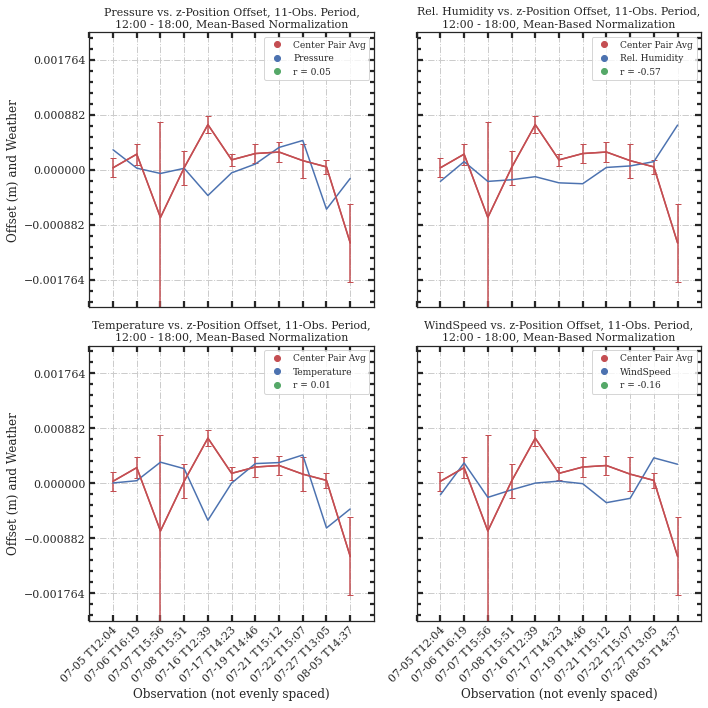

In [15]:
fig, axes = plt.subplots(2,2,figsize=(10,10),sharey=True,sharex=True)

ax = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
weaLabels = ['Pressure','Rel. Humidity','Temperature','WindSpeed']

handles = []
for i in range(4):
    temp = pd.DataFrame(np.column_stack((xMag,magAvg[0,:,index],magAvg[0,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='r')
    ax[i].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color='r',capsize=3)
    
    temp = pd.DataFrame(np.column_stack((xMag,magWea[nearestWeatherStation,:,i])),columns=['x', 'y'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='b')
    
    handles.append([Line2D([0],[0],marker='o',color='r',label=pairLoc[0]+' Pair Avg',linewidth=0),
          Line2D([0],[0],marker='o',color='b',label=weaLabels[i],linewidth=0),
          Line2D([0],[0],marker='o',color='g',label="r = %0.2f"%pearsonr(magAvg[0,:,index],magWea[nearestWeatherStation,:,i])[0],linewidth=0)])
    
    #if magProbsAvg[0,0,0] != "":
        #for row in range(np.where(magProbsAvg[0,:,0] == "")[0][0]):
            #ax[i].scatter(float(magProbsAvg[0,row,1]),0,s=500,c='none',edgecolor='r',linewidth=1)
            
    #if magWeaProbs[0,0,0] != "":
        #for row in range(np.where(magWeaProbs[0,:,0] == "")[0][0]):
            #ax[i].scatter(float(magWeaProbs[0,row,1]),0,s=500,c='none',edgecolor='b',linewidth=1)

for i in range(4):
    ps.plotNonDescript(ax[i],title=weaLabels[i]+' vs. '+graph+'-Position Offset, '+str(numObs)+'-Obs. Period,\n'+
                   timeRange[0]+':00 - '+timeRange[1]+':00, Mean-Based Normalization',ymax=ymaxMag,
                   ymin=yminMag,titlesize=11,xlabel='Observation (not evenly spaced)',ylabel='Offset (m) and Weather',
                       xticks=xticks,xticklabels=timeSeries,yticks=True,handles=handles[i])

plt.tight_layout()

if Save:
    plt.savefig(directory+subdirName+'magWea'+graph.capitalize()+'.png', bbox_inches='tight')
    plt.close()
else: plt.show()

# delta (offset & weather) w/ mean-based normalization

### specific initializations

In [16]:
deltaWeaProbs = np.empty((np.shape(weaants)[0],numObs-1,2),dtype='U25')
deltaWea = np.empty((np.shape(weaants)[0],numObs-1,6),dtype='float')
x = range(1,numObs)
xticks = np.array(range(numObs+1),dtype='float')-0.5
if timeToScale:
    xticks = np.arange(maxTimeIndex+1)-0.5
else:
    xticks = np.array(range(numObs+1),dtype='float')-0.5
    
    # Prepare time labels
    timeSeries = []
    temp = pd.read_csv(directory+'/offsetdata/'+refants[0]+'.csv')[['time']]
    for time in range(temp.shape[0]):
        timeSeries.append(tc.UnixtoFormattedTime(temp.loc[time]))
    
    timeSeries.append("")

########## delta-specific wea data

# Data extraction from weatherdata directory
for ant in range(np.shape(weaants)[0]):
    arr = pd.read_csv(directory+'/weatherdata/'+weaants[ant]+'.csv')
    arr = arr.loc[:,'pressure':'windMax']
    for obs in range(numObs-1):
        # If there's a problem in the data, prep it for the next loop
        if arr.iloc[obs+1].isnull().values.any() or arr.iloc[obs].isnull().values.any():
            L = np.where(deltaWeaProbs[ant,:,0] == "")[0][0]
            deltaWeaProbs[ant,L,0] = obs
            deltaWeaProbs[ant,L,1] = xMag[obs]
            deltaWea[ant,obs,:] = np.nan
        # Else, transfer the data
        else:  
            deltaWea[ant,obs,:3] = arr.iloc[obs+1,:3]-arr.iloc[obs,:3]
            if arr.iat[obs+1,index+3] > arr.iat[obs,index+3]:
                deltaWea[ant,obs,3:] = arr.iloc[obs+1,3:]
            else: deltaWea[ant,obs,3:] = arr.iloc[obs,3:]
            
# If there's a problem in the data, take the data from the previous observation (or the next, if the previous is
# not available) and update magProbs, which will allow us to circle the problem areas in our plot.
for ant in range(np.shape(weaants)[0]):
    if deltaWeaProbs[ant,0,0] != "":
        for prob in range(np.where(deltaWeaProbs[ant,:,0] == "")[0][0]):
            if int(deltaWeaProbs[ant,prob,0]) == 0: deltaWea[ant,int(deltaWeaProbs[ant,prob,0]),:] = deltaWea[ant,int(deltaWeaProbs[ant,prob,0])+1,:]
            else: deltaWea[ant,int(deltaWeaProbs[ant,prob,0]),:] = deltaWea[ant,int(deltaWeaProbs[ant,prob,0])-1,:]
                
# Remove windDir and windMax
temp = np.empty((np.shape(weaants)[0],numObs-1,4))
temp[:,:,0] = deltaWea[:,:,0]
temp[:,:,1] = deltaWea[:,:,1]
temp[:,:,2] = deltaWea[:,:,2]
temp[:,:,3] = deltaWea[:,:,4]
deltaWea = temp

### mean-based normalization

In [17]:
for ant in range(np.shape(weaants)[0]):
    for i in range(4):
        offset = np.average(deltaWea[ant,:,i])
        deltaWea[ant,:,i] = deltaWea[ant,:,i]-offset

### mean-based scaling

In [18]:
posPoints = []
negPoints = []
for i in range(numObs-1):
    if deltaAvg[0,i,index] > 0: posPoints.append(deltaAvg[0,i,index])     
avg1 = np.average(np.array(posPoints,dtype='float'))

if os.listdir(genDir)[0][:3] == "uid": uid = os.listdir(genDir)[0]
else: uid = os.listdir(genDir)[1]
    
counter = 1
antMissing = True    
while antMissing == True:
    antMissing = False
    try:
        uid = os.listdir(genDir)[1+counter]
        nearestWeatherStation = mc.nearestWeatherStation(genDir+uid+'/',[refants[0],refants[1]])
    except:
        antMissing = True
        
    if antMissing == False: nearestWeatherStation = mc.nearestWeatherStation(genDir+uid+'/',[refants[0],refants[1]])
    counter += 1
    
for ant in range(len(weaants)):
    if nearestWeatherStation == weaants[ant]:
        nearestWeatherStation = ant

avg2 = np.empty((4),dtype='float')
for i in range(4):
    posPoints = []
    negPoints = []
    for j in range(numObs-1):
        if deltaWea[nearestWeatherStation,j,i] > 0: posPoints.append(deltaWea[nearestWeatherStation,j,i])
    avg2[i] = np.average(np.array(posPoints,dtype='float'))

scaleFactor = avg1 / avg2

for i in range(4): deltaWea[nearestWeatherStation,:,i] = deltaWea[nearestWeatherStation,:,i] * scaleFactor[i]

### extrema

In [19]:
ymaxDelta,yminDelta = ymaxDelta*0.5,yminDelta*0.5

## plot

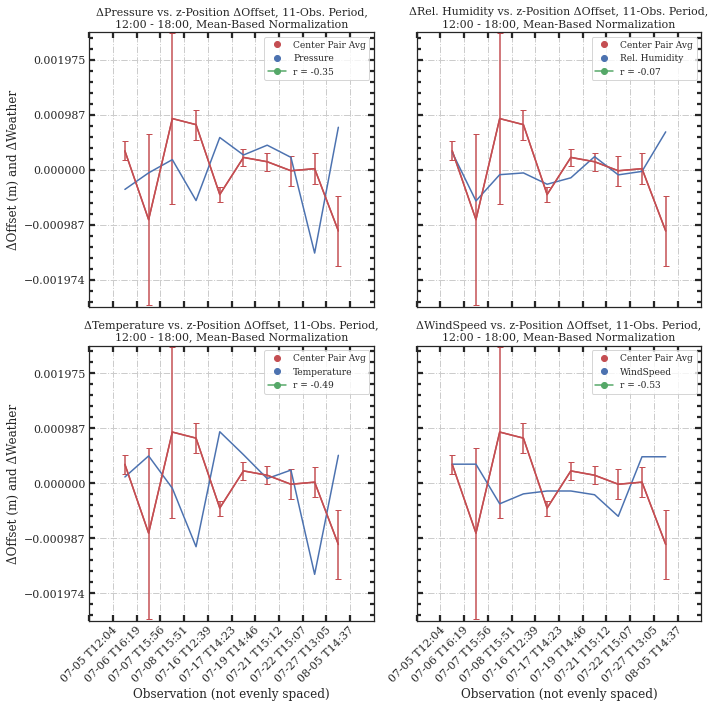

In [20]:
fig, axes = plt.subplots(2,2,figsize=(10,10),sharey=True,sharex=True)

ax = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]
weaLabels = ['Pressure','Rel. Humidity','Temperature','WindSpeed']
weaIndices = [0,1,2,4]

handles = []
for i in range(4):
    temp = pd.DataFrame(np.column_stack((xDelta,deltaAvg[0,:,index],deltaAvg[0,:,index+3])),columns=['x', 'y','err'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='r')
    ax[i].errorbar(temp.loc[:,'x'],temp.loc[:,'y'],temp.loc[:,'err'],color='r',capsize=3)
    
    temp = pd.DataFrame(np.column_stack((xDelta,deltaWea[nearestWeatherStation,:,i])),columns=['x', 'y'])
    sb.lineplot(ax=ax[i], x='x', y='y', data=temp, color='b')
    
    handles.append([Line2D([0],[0],marker='o',color='r',label=pairLoc[0]+' Pair Avg',linewidth=0),
          Line2D([0],[0],marker='o',color='b',label=weaLabels[i],linewidth=0),
            Line2D([0],[0],marker='o',color='g',label="r = %0.2f"%pearsonr(deltaAvg[0,:,index],deltaWea[nearestWeatherStation,:,i])[0])])
    
    if deltaProbsAvg[0,0,0] != "":
        for row in range(np.where(deltaProbsAvg[0,:,0] == "")[0][0]):
            ax[i].scatter(float(deltaProbsAvg[0,row,1]),0,s=500,c='none',edgecolor='r',linewidth=1)

    if deltaWeaProbs[0,0,0] != "":
        for row in range(np.where(deltaWeaProbs[0,:,0] == "")[0][0]):
            ax[i].scatter(float(deltaWeaProbs[0,row,1]),0,s=500,c='none',edgecolor='b',linewidth=1)
            
for i in range(4):
    ps.plotNonDescript(ax[i],title='Δ'+weaLabels[i]+' vs. '+graph+'-Position ΔOffset, '+str(numObs)+'-Obs. Period,\n'+
                   timeRange[0]+':00 - '+timeRange[1]+':00, Mean-Based Normalization',ymax=ymaxDelta,
                   ymin=yminDelta,titlesize=11,xlabel='Observation (not evenly spaced)',ylabel='ΔOffset (m) and ΔWeather',
                       xticks=xticks,xticklabels=timeSeries,yticks=True,handles=handles[i])

plt.tight_layout()

if Save:
    plt.savefig(directory+subdirName+'deltaWea'+graph.capitalize()+'.png', bbox_inches='tight')
    plt.close()
    print("done")
else: 
    plt.show()